In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

import sys
sys.path.insert(1, '../library')
sys.path.insert(2, '../python_library')

import pyram as pr

from sklearn.linear_model import LinearRegression
import scipy
from itertools import combinations

from scipy.spatial import distance
from scipy.optimize import minimize

%matplotlib inline

Welcome to pyram: your Raman analysis library!


# Charge example spectra

In [2]:
pr.charge_lib('RRUFF_sub')

lib = pr.lib()
lib_names = list(lib.keys())
pr.cwd('example_data')
pr.set_alias()

Charging pure spectra library, needs around a minute ....
Done. Good work!
txt0  ->  Sample01_A_10x6s_633nm_G1200_F100__Ox100LWD.txt
txt1  ->  Sample01_B_10x30s_633nm_G1200_F1__Ox100LWD.txt
txt2  ->  Sample01_C_10x20s_633nm_G1200_F10__Ox100LWD.txt
txt3  ->  Sample01_D_6x4s_633nm_G1200_F100__Ox10.txt
txt4  ->  Sample01_E_6x4s_633nm_G1200_F100__Ox100LWD.txt
txt5  ->  Sample01_F_10x5s_633nm_G1200_F0_1__Ox100LWD.txt
txt6  ->  Sample01_G_6x10s_633nm_G1200_F10__Ox100LWD.txt
txt7  ->  Sample01_H_10x10s_633nm_G1200_F10__Ox100LWD.txt
txt8  ->  Sample01_I_10x10s_633nm_G1200_F25__Ox100LWD.txt
txt9  ->  Sample01_J_10x5s_633nm_G1200_F10__Ox100LWD.txt
txt10  ->  Sample01_K_10x10s_633nm_G1200_F10__Ox100LWD.txt
txt11  ->  Si_calibration_A_60x1s_633nmnm_G1200_F100__Ox100.txt


# Simultaneous bkg and spectra fit

## 1D search in the library

## Select the spectra

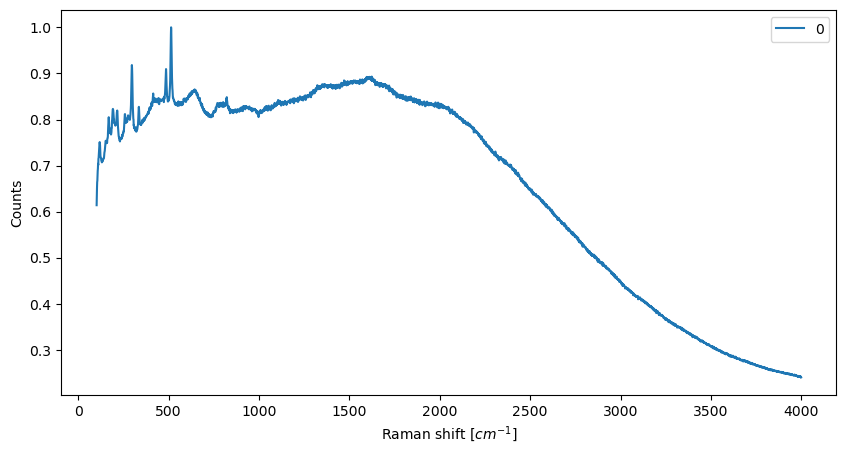

In [16]:
# take an unknown spectra with bkg

S=pr.type2spectra('txt8')
pr.plot(S)

## Prepare resized library
The referance library must be resied according to the portion of spectrum we are working with.

In [44]:
########################

S

# BKG
sigma = 80
p = 100
delta = sigma #(>> sigma)
method = 'gauss'
nu_min = 200
nu_max = 1400


#FIT
shift = 5

plot = True
#######################

In [45]:
# normalize S
S[1] = S[1]/np.linalg.norm(S[1])

# resize S
if nu_min is not None:
    S = S[:,S[0]>nu_min]
if nu_max is not None:
    S = S[:,S[0]<nu_max]

# create matrix LIB

LIB = np.zeros((len(lib_names), len(S[0])))

for i in range(len(lib_names)):
    P = np.copy(lib[lib_names[i]])

    # restringo P se troppo grande
    if P[0][0]<S[0][0] or P[0][-1]>S[0][-1]:
        P = P[:,P[0]>=S[0][0]]
        P = P[:,P[0]<=S[0][-1]]


    # generate PAD with zeros of P se troppo piccolo
    n_min = np.where(S[0]==P[0][0])
    n_max = np.where(S[0]==P[0][-1])
    
    P_pad = np.copy(S)
    P_pad[1][n_min[0][0]:n_max[0][0]+1] = P[1]
    P_pad[1][0:n_min[0][0]] *= 0 
    P_pad[1][n_max[0][0]:] *= 0

    LIB[i] = P_pad[1]/(np.linalg.norm(P_pad[1]))

## Matrice di bkg template functions

In [46]:
# generate array of bkg template functions

# gaussian function in numpy
def gauss(x, mu, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))

# sinc function in numpy
def sinc(x, mu, sigma):
    return np.sinc((x-mu)/sigma)

# polynomial function in numpy
def poly(x, n):
    return x**n


mus = np.linspace(S[0,0]-delta, S[0,-1]+delta, p)

G = np.zeros((p,len(S[0])))

if method == 'gauss':
    for i in range(p):
        G[i] = gauss(S[0], mus[i], sigma)

if method == 'sinc':
    for i in range(p):
        G[i] = sinc(S[0], mus[i], sigma)

if method == 'poly':
    for i in range(p):
        G[i] = poly(np.linspace(0,1,len(S[1])), i)

,name,ID,match,res
0,Albite__R050402__Raman__780,82,0.987332,0.000011
1,Albite__R050253__Raman__514,77,0.987092,0.000014
2,Albite__R050402__Raman__514,80,0.986429,0.000014
3,Albite__R050253__Raman__780,79,0.984166,0.000013
4,Albite__R040129__Raman__514,74,0.982466,0.000015
5,Rubicline__R070044__Raman__785,3742,0.981372,0.000016
6,Albite__R040068__Raman__532,72,0.976285,0.000024
7,Albite__R050253__Raman__532,78,0.972113,0.000027
8,Albite__R040129__Raman__532,75,0.971158,0.000026
9,Albite__R040068__Raman__514,71,0.968096,0.000028


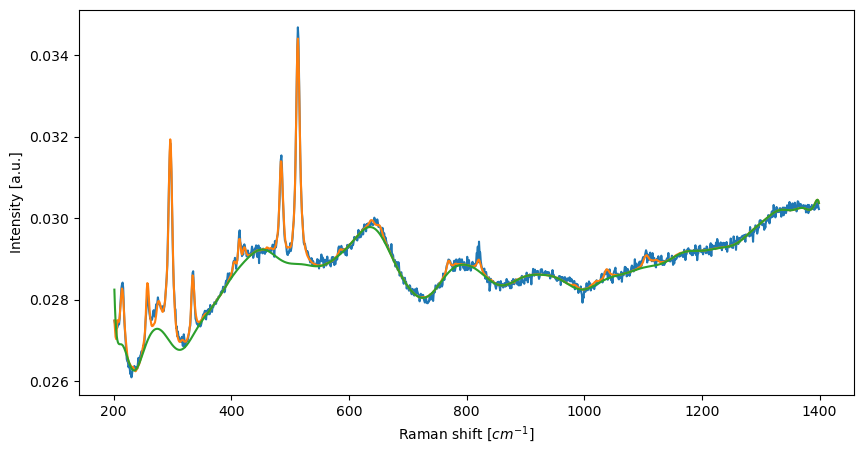

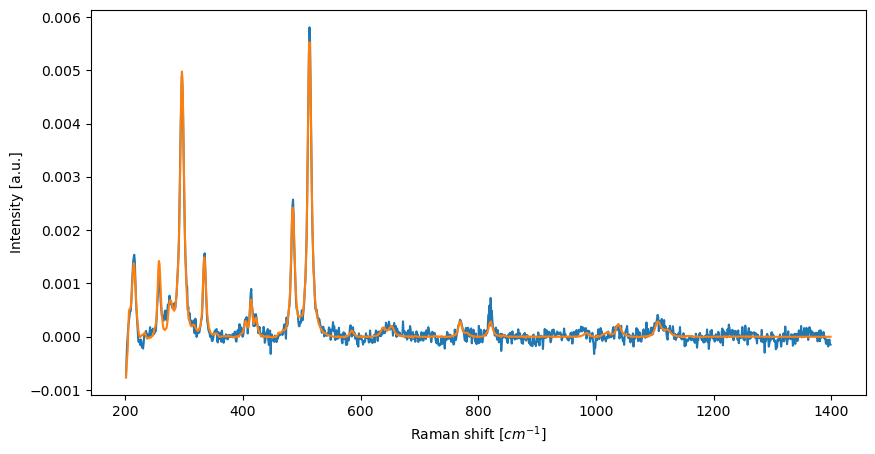

In [48]:
# FIT with shifts

# cosine similarity between two vectors
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))



shift_vec = np.arange(-shift,shift+1)
Ps = np.zeros((2*shift+1, len(S[0])))
out = []

for i in range(len(lib_names)):

    for s in shift_vec:

        P_shifted = np.roll(LIB[i],s)

        if s>0:
            P_shifted[:s] *= 0
        if s<0:
            P_shifted[s:] *= 0

        Ps[s] = P_shifted

    #### fit
    Y = np.append(Ps, G, axis=0)
    fit = scipy.linalg.lstsq(Y.transpose(), S[1])

    
    # salvo risultato
    bkg = (G.transpose() * fit[0][2*shift+1:]).sum(axis=1)
    I = fit[0][:2*shift+1]
    P = (Ps.transpose() * I).sum(axis=1)

    res = ((bkg+P-S[1])**2).sum()
    
    # riassumo info

    match = cosine_similarity(S[1]-bkg, P)

    # SALVO
    out.append([lib_names[i], i, match, res, P, bkg, I.sum()])
    
out = pd.DataFrame(out, columns=['name', 'ID', 'match', 'res', 'P', 'bkg','I']).sort_values(by='res', ascending=True).reset_index(drop=True)
out = out[out['res']<out['res'][0]*10]
out = pd.DataFrame(out, columns=['name', 'ID', 'match', 'res', 'P', 'bkg','I']).sort_values(by='match', ascending=False).reset_index(drop=True)

out = out[out['I']>0]
display(out[['name','ID','match','res']].head(15))


# PLOTS
if plot:
    plt.figure(figsize=(10,5))
    plt.plot(S[0], S[1], label='signal')
    plt.plot(S[0], out.P[0]+out.bkg[0], label=out.name[0])
    plt.plot(S[0], out.bkg[0], label='background')
    plt.xlabel(r'Raman shift [$cm^{-1}$]')
    plt.ylabel('Intensity [a.u.]')

    plt.figure(figsize=(10,5))
    plt.plot(S[0], S[1]-out.bkg[0], label='signal')
    plt.plot(S[0], out.P[0], label='fit')
    plt.xlabel(r'Raman shift [$cm^{-1}$]')
    plt.ylabel('Intensity [a.u.]')